In [ ]:
! pip install shap

In [ ]:
! pip install optuna

In [ ]:
! pip install optuna-integration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering  import
from sklearn.model_selection import train_test_split ,learning_curve

# Model import
import lightgbm as lgb
from lightgbm import LGBMClassifier ,LGBMRegressor

# Evaluate import
import optuna
import shap
# print the JS visualization code to the notebook
shap.plots.initjs()
from sklearn import metrics
from sklearn.metrics import accuracy_score ,roc_auc_score ,roc_curve ,classification_report ,confusion_matrix

# sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# Load ata

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
X = df.drop(columns =['Class'])
y = df['Class']

print('X:', X.shape) # (284807, 30)
print('Y:', y.shape) # (284807,)

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
counts = np.bincount(y)
for i, count in enumerate(counts):
    print(f"Class {i}: {count} instances")

Class 0: 284315 instances

Class 1: 492 instances

# Split Data
資料分割，將資料集拆分為訓練集、驗證集、測試集

In [ ]:
# 訓練60%，驗證20%，測試20%
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

列出訓練資料、驗證資料、測試資料的標籤個數

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 170567, 1: 316}

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 56884, 1: 78}

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 56864, 1: 98}

# Optuna

In [ ]:
def objective(trial):
  # 訓練60%，驗證20%，測試20%
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
  # 將數據集轉成lgb特徵的數據集格式
  lgb_train = lgb.Dataset(X_train, label=y_train)
  lgb_val = lgb.Dataset(X_val, label=y_val)
  lgb_test = lgb.Dataset(X_test,label=y_test)
  params = {
      'task': 'train',
      'boosting_type': 'gbdt',
      "objective": "binary",
      "metric": "auc",
      'verbose':-1,
      # "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
      "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
      "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
      "num_leaves": trial.suggest_int("num_leaves", 2, 256),
      "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
      "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      'is_unbalance': True
  }
  # Add a callback for pruning.
  pruning_callback = optuna.integration.LightGBMPruningCallback(trial,"auc")
  gbm = lgb.train(params ,lgb_train ,valid_sets=[lgb_val] ,callbacks=[pruning_callback])

  preds = gbm.predict(X_test)
  pred_labels = np.rint(preds)
  accuracy = accuracy_score(y_test ,pred_labels)
  return accuracy

In [ ]:
# 最大化評估函數的返回值（例如準確率）時，應選擇 "maximize"
# 最小化評估函數的返回值（例如損失函數）時，應選擇 "minimize"
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize")
study.optimize(objective, n_trials=10, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

In [ ]:
trial.params

In [ ]:
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

從圖表中觀察Objective Value隨著每次Trial的變化情況，Trial為5時，Objective Value趨於Best Value(1)

In [ ]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show(config=plotly_config)

*   從optuna輸出的視覺化圖表中我們可以發現 bagging_freq(執行裝袋的頻率,bagging 僅在 bagging_freq > 0 且 bagging_fraction < 1.0 時有效)最為重要，其他依序為num_leaves(一個樹狀結構中的的最大分葉數量)，
min_child_samples(一片葉子中的最少資料量)。



最後將訓練好的params，傳遞給LGBMClassifier，重新fit資料，且將verbose設定為-1,這樣列印訊息僅會顯示嚴重錯誤。

In [ ]:
lgbm_params = {
    'verbose':-1
}

lgbm_model = lgb.LGBMClassifier(**trial.params ,**lgbm_params)
lgbm_model.fit(X_train, y_train)

# Shap

解釋模型

In [ ]:
# Tree SHAP 來解釋整個資料集
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer(X)

In [ ]:
print("X shape:", X.shape)
print("SHAP values shape:", shap_values.shape)

X shape: (284807, 30)

SHAP values shape: (284807, 30)

In [ ]:
# waterfall 單筆資料解釋
shap.plots.waterfall(shap_values[0])

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X)

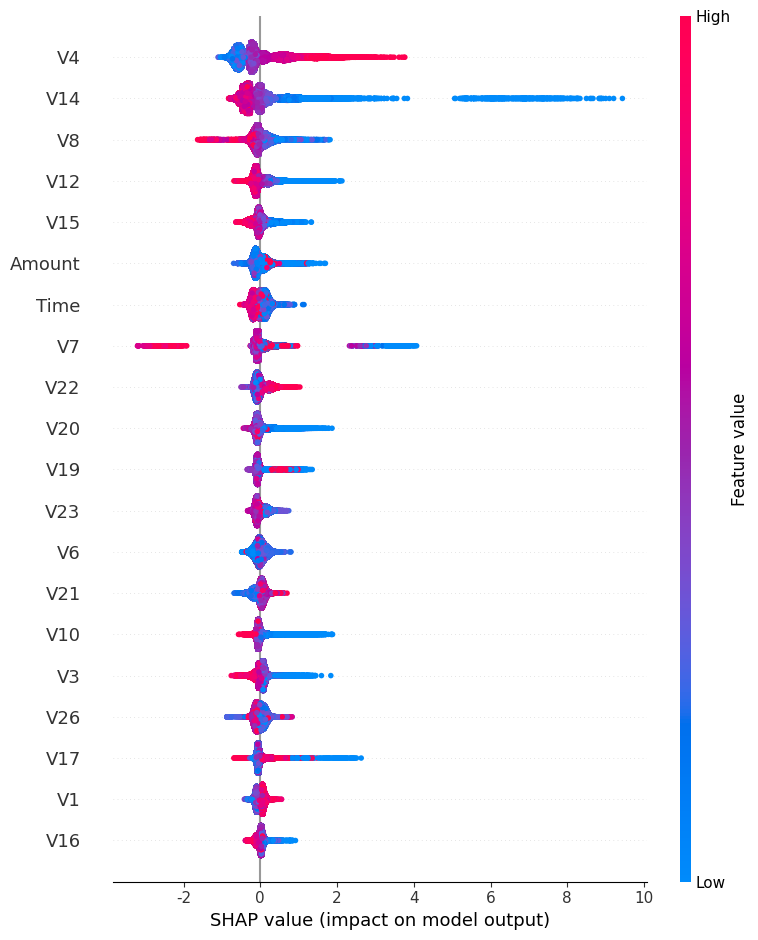

* V4越大，具有更大的總體模型影響
* V14越小，具有更大的總體模型影響
* V8的大小,某種程度都會影響預測值


In [ ]:
# Bar chart of mean importance
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
# Global bar plot
shap.plots.bar(shap_values)

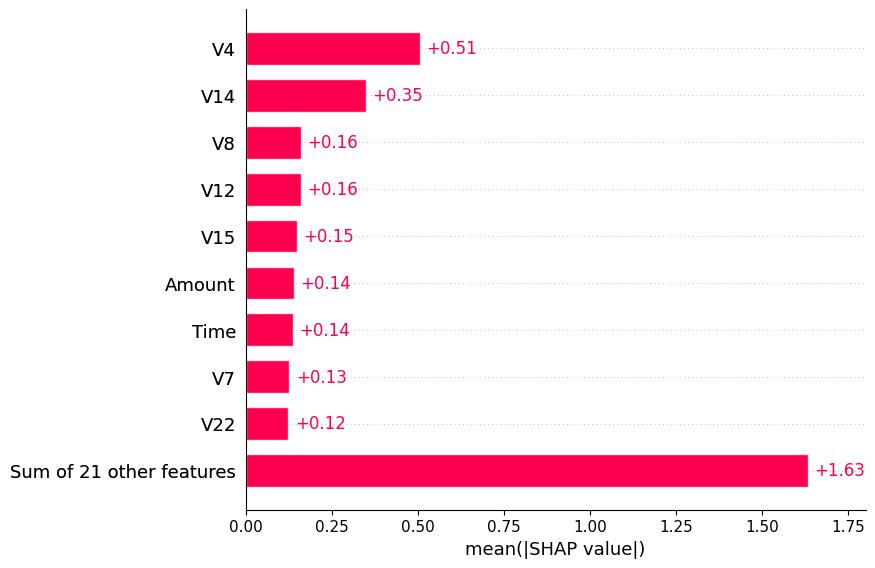

* V4：+0.51
* V14：+0.35
* V8：+0.16

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values.values, X_train)

# Evaluate

In [ ]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                    rownames=['Actual'],
                    colnames=['Predicted'])
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    if title is not None:
        plot.set_title(title)
    plt.show()

def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)

    print("Training Set Evaluation:")
    print("Accuracy:", train_accuracy)
    print("Confusion Matrix:")
    print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)

    print("Testing Set Evaluation:")
    print("Accuracy:", test_accuracy)
    print("Confusion Matrix:")
    print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)

    plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix")

evaluate_model_performance(lgbm_model, X_train, X_test, y_train, y_test)

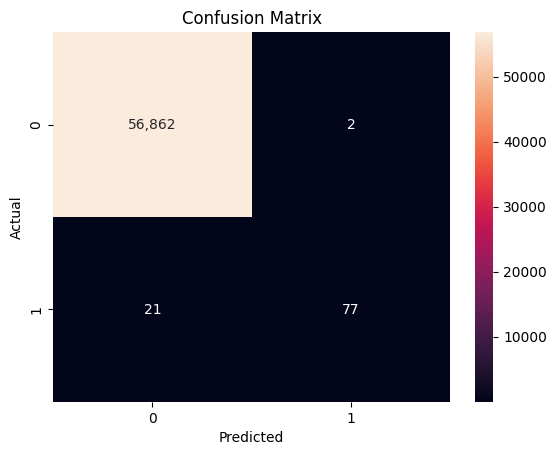

模型在訓練或是測試都表現良好，Testing Set中，預測沒有盜刷的precision達到1.00，有盜刷則是0.95，模型的Accuracy則達到了1.00，但評估結果不該只看Accuracy等其他指標，還需輸出混淆矩陣來查看。

*   真實盜刷資料總共有98筆，其中77筆被成功辨識出來，21筆沒有被辨識出來。
*   沒有被盜刷的資料總共有56864筆，其中有2筆資料沒到盜刷卻被預測為有盜刷，剩下的56862筆預測皆正確。





# Learning Curve

In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

    plt.legend(loc="best")
    plt.show()
    # Print additional information
    print("Train Sizes:", train_sizes)
    print("Train Scores Mean:", train_scores_mean)
    print("Test Scores Mean:", test_scores_mean)
plot_learning_curve(lgbm_model, X_train, y_train)

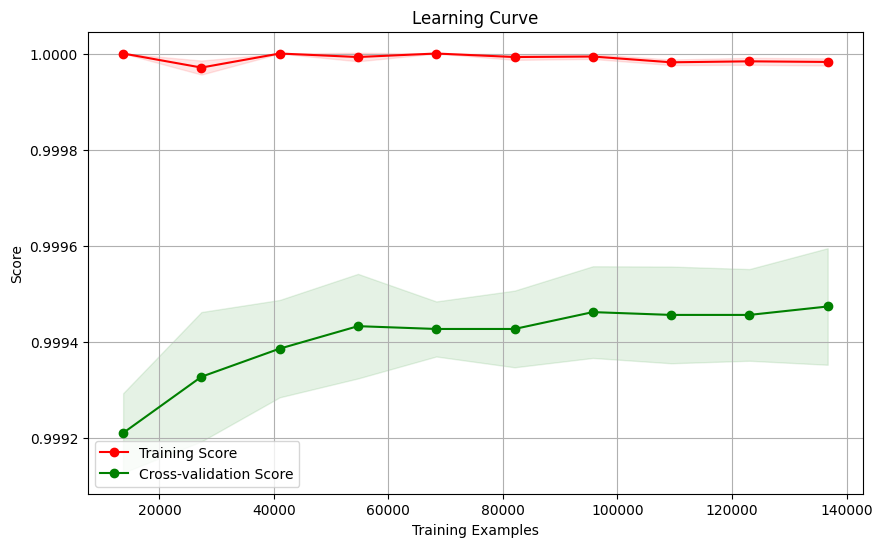

*   訓練分數的平均值逐漸降低，從1.0降到約0.99998左右。
*   交叉驗證分數的平均值逐漸增加，從約0.99921到約0.99947。這是因為隨著訓練集的大小增加，模型在交叉驗證集上的表現也更好，因此交叉驗證分數可能會略微增加。

